In [1]:
import pandas as pd
import numpy as np
import matplotlib
import torch
from glob import glob
import os
import json
from ecog_speech import datasets, feature_processing, experiments, utils
from ecog_speech.models import base
from tqdm.auto import tqdm

%matplotlib inline

/home/morgan/.conda/envs/venv/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


### Load up a single result

In [2]:
#result_file = '/export/Projects_GOLIATH/CMSCResearch/ECOGSpeech/ecog_speech/quick_results/1620432565_bf95a269-d1ba-4f3c-a5e1-9449d8105299_TL.json'
result_file = '../ecog_speech/results_per_patient_sn_2105/1620642815_deb8e100-8f45-4f95-b392-15fabbe66634_TL.json'
results = json.load(open(result_file))

In [3]:
results.keys()

dict_keys(['name', 'datetime', 'uid', 'batch_losses', 'best_model_epoch', 'num_trainable_params', 'num_params', 'model_kws', 'clf_reports', 'f1', 'accuracy', 'precision', 'recall', 'model_name', 'dataset', 'train_sets', 'cv_sets', 'test_sets', 'random_labels', 'learning_rate', 'dense_width', 'sn_n_bands', 'sn_kernel_size', 'sn_padding', 'n_cnn_filters', 'dropout', 'dropout_2d', 'in_channel_dropout_rate', 'batchnorm', 'roll_channels', 'shuffle_channels', 'cog_attn', 'bw_reg_weight', 'track_sinc_params', 'power_q', 'n_epochs', 'batch_size', 'device', 'save_model_path', 'tag', 'result_dir', 'low_hz_frame', 'high_hz_frame', 'path'])

### How did it train?
- This looks...okay

<AxesSubplot:>

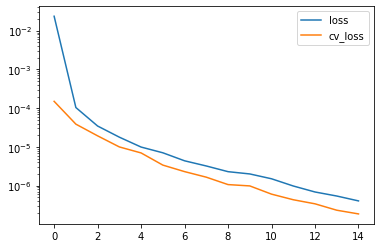

In [4]:
pd.DataFrame(results['batch_losses']).T.plot(logy=True)

### Load up the SincNet parameters
- These results only available if track_sinc_params is set

Loaded sinc params


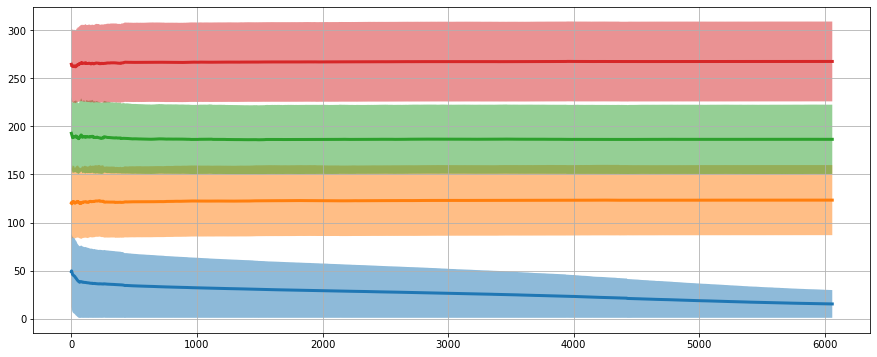

In [5]:
if results['track_sinc_params']:
    print("Loaded sinc params")
    lowhz_df = pd.read_json(results['low_hz_frame']).sort_index()
    highhz_df = pd.read_json(results['high_hz_frame']).sort_index()
    centerhz_df = (highhz_df + lowhz_df)/2.

    ax = None
    for c in lowhz_df.columns:
        ax = centerhz_df[c].plot(figsize=(15, 6), lw=3, ax=ax)
        ax.fill_between(centerhz_df.index,
                        lowhz_df[c], 
                        highhz_df[c], 
                        alpha=0.5)
    ax.grid(True)
#ax.legend(False)

### Bring in the 

In [6]:
model_kws = results['model_kws']

model_kws

{'in_channels': 96,
 'n_bands': 4,
 'n_cnn_filters': 32,
 'sn_padding': 15,
 'sn_kernel_size': 31,
 'in_channel_dropout_rate': 0.0,
 'fs': 600,
 'cog_attn': False,
 'window_size': 300,
 'dropout': 0.0,
 'dropout2d': False,
 'batch_norm': True,
 'dense_width': None}

In [7]:
#model_path = os.path.join('../ecog_speech/', results['save_model_path'])
model_path = os.path.join('/export/Projects_GOLIATH/CMSCResearch/ECOGSpeech/ecog_speech/', results['save_model_path'])

In [8]:
model_path

'/export/Projects_GOLIATH/CMSCResearch/ECOGSpeech/ecog_speech/results_per_patient_sn_2105/models/deb8e100-8f45-4f95-b392-15fabbe66634.torch'

In [9]:
model = base.BaseMultiSincNN(**model_kws)

#with open('../ecog_speech/test_results/t_cog_attn_model_2.torch', 'rb') as f:
with open(model_path, 'rb') as f:
    model_state = torch.load(f)
    #mut_state = pickle.load(f)

model.load_state_dict(model_state)

torch.Size([32, 544])
Unsqueeze()
torch.Size([32, 96, 1, 300])
----
MultiChannelSincNN(
  (sinc_nn): SincConv()
  (sinc_nn_list): ModuleList(
    (0): SincConv()
    (1): SincConv()
    (2): SincConv()
    (3): SincConv()
    (4): SincConv()
    (5): SincConv()
    (6): SincConv()
    (7): SincConv()
    (8): SincConv()
    (9): SincConv()
    (10): SincConv()
    (11): SincConv()
    (12): SincConv()
    (13): SincConv()
    (14): SincConv()
    (15): SincConv()
    (16): SincConv()
    (17): SincConv()
    (18): SincConv()
    (19): SincConv()
    (20): SincConv()
    (21): SincConv()
    (22): SincConv()
    (23): SincConv()
    (24): SincConv()
    (25): SincConv()
    (26): SincConv()
    (27): SincConv()
    (28): SincConv()
    (29): SincConv()
    (30): SincConv()
    (31): SincConv()
    (32): SincConv()
    (33): SincConv()
    (34): SincConv()
    (35): SincConv()
    (36): SincConv()
    (37): SincConv()
    (38): SincConv()
    (39): SincConv()
    (40): SincConv()
    (41

<All keys matched successfully>

In [10]:
#data_k_l = datasets.NorthwesternWords.make_tuples_from_sets_str(results['train_sets'])

#data_k = datasets.NorthwesternWords.all_patient_maps['MC'][21][1]
#data_k_l = [data_k]

### Load up the data we want to test - by default just use the test fold
- TODO: The results file doesn't track the sensors that were actually used, so you'd need to load the train sets to appropriatley get the sensors - or just manually set them
    - In this case, the train and test set happen to use the same sensors (or at least number of sensors...?)

In [11]:
data_k_l = datasets.NorthwesternWords.make_tuples_from_sets_str(results['test_sets'])

In [12]:
data_k = data_k_l[0]

In [13]:
nww = datasets.NorthwesternWords(patient_tuples=data_k_l)

---19-1-1-Mayo Clinic---

Found electrodes metadata, N trodes = 96


Audio FS = 48000
Duplicate words (n=2): cup, pig
ECOG_signal shape: (422400, 96) [(Timedelta('0 days 00:00:00'), Timedelta('0 days 00:05:51.999166667'))]
Found electrodes metadata, N trodes = 96
No bad sensors
Selected sensors (n=96): 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95
Audio shape: (16887643,) [(Timedelta('0 days 00:00:00'), Timedelta('0 days 00:05:51.825875'))]

Selected 96 sensors
--
remap: ecog <- ecog_subs
remap: fs_signal <- fs_signal_subs
remap: stim <- stim_subs
remap: stim_diff <- stim_diff_subs
Sample Words: 0-much,1-fish,2-ride,3-bit,4-dill
(600, Timedelta('0 days 00:00:00.500000'))
Max window size: 300


In [14]:
data_map = nww.data_maps[data_k]

### Setup the data to be run through a torch model easily
- If running with a GPU, need to send model and data to device in order to utilize

In [15]:
import torch
from tqdm.auto import tqdm
ecog_torch_arr = torch.from_numpy(data_map['ecog'].values)

In [16]:
ecog_torch_arr.shape

torch.Size([211200, 96])

In [17]:
win_size = nww.ecog_window_size
win_step = 1
all_ecog_dl = torch.utils.data.DataLoader([ecog_torch_arr[_ix:_ix+win_size].T 
                                              for _ix in range(0, ecog_torch_arr.shape[0] - win_size, win_step)], 
                                                  batch_size=1024, num_workers=6)


### Run predictions samples

In [18]:
with torch.no_grad():
    all_ecog_out = [model(x) for x in tqdm(all_ecog_dl)]

### Parse the predictions into a time series

In [19]:
all_ecog_pred_s = pd.Series([_v.item() for v in all_ecog_out for _v in v], 
          index=data_map['ecog'].iloc[range(win_size, ecog_torch_arr.shape[0], win_step)].index,
         name='pred_proba')

***
Bonus - try out some torch script and do some performance tests
- This is a big slow model - nearly one secondm and get's slower with script/optim...?

In [20]:
from torch.utils.mobile_optimizer import optimize_for_mobile
my_script_module = torch.jit.script(model)
optimized_torchscript_model = optimize_for_mobile(my_script_module.eval())

In [21]:
optimized_torchscript_model.eval();
my_script_module.eval();

In [22]:
t_sample = next(iter(all_ecog_dl))

In [23]:
%%timeit
with torch.no_grad():
    optimized_torchscript_model(t_sample)

/home/morgan/.conda/envs/venv/lib/python3.8/site-packages/torch/nn/modules/module.py:727: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370124688/work/c10/core/TensorImpl.h:848.)
  result = self.forward(*input, **kwargs)


985 ms ± 193 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%%timeit
with torch.no_grad():
    my_script_module(t_sample)

811 ms ± 304 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%%timeit
with torch.no_grad():
    model(t_sample)

778 ms ± 88.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


****

### Map each unique stim code (`wrd_id`) to a tuple of it's speaking section and leading silence

In [27]:
plt_stim_s = data_map['stim']
t_indices_s  = {wrd_id: (nww.sample_index_maps[data_k].get(wrd_id), nww.sample_index_maps[data_k].get(-wrd_id))
                for wrd_id in plt_stim_s.unique() if wrd_id != 0}

In [28]:
plt_dfs, neg_plt_dfs = list(), list()
for wrd_id, (wrd_ix, sil_ix)  in t_indices_s.items():
    #_cols = [f'neg_{wrd_id}', f'{wrd_id}']
    s = pd.Series(0, index=data_map['stim'].index, name=wrd_id)
    s.loc[wrd_ix[0].min():wrd_ix[-1].max()] = 1
    plt_dfs.append(s)
    
    s = pd.Series(0, index=data_map['stim'].index, name=-wrd_id)
    s.loc[sil_ix[0].min():sil_ix[-1].max()] = 1
    neg_plt_dfs.append(s)
    
plt_label_df = pd.concat(plt_dfs, axis=1)

**plt_label_df has a column for each word code, set to 1 when that is the word being spoken**
- Calling plt_label_df.any(axis=1) will therefore tell us if any word is being spoken at any point in time

In [29]:
plt_label_df.head()

104  90   75   54   57   7    40   106  22   18   \
0 days 00:00:00              0    0    0    0    0    0    0    0    0    0   
0 days 00:00:00.001666667    0    0    0    0    0    0    0    0    0    0   
0 days 00:00:00.003333333    0    0    0    0    0    0    0    0    0    0   
0 days 00:00:00.005000       0    0    0    0    0    0    0    0    0    0   
0 days 00:00:00.006666667    0    0    0    0    0    0    0    0    0    0   

                           ...  85   9    77   63   112  105  45   49   91   \
0 days 00:00:00            ...    0    0    0    0    0    0    0    0    0   
0 days 00:00:00.001666667  ...    0    0    0    0    0    0    0    0    0   
0 days 00:00:00.003333333  ...    0    0    0    0    0    0    0    0    0   
0 days 00:00:00.005000     ...    0    0    0    0    0    0    0    0    0   
0 days 00:00:00.006666667  ...    0    0    0    0    0    0    0    0    0   

                           62   
0 days 00:00:00              0  
0 days 00:00:00.001666667    0  
0 days 00:00:00.003333333    0  
0 days 00:00:00.005000       0  
0 days 00:00:00.006666667    0  

[5 rows x 115 columns]

### Do the big time series plot
- TODO: The rolling agg PLUS the pandas time series index oddness could make some of these lines offset by a bit
    - Pandas time series will round down the right side of a slice to the nearest second... not sure how this is decided/controled

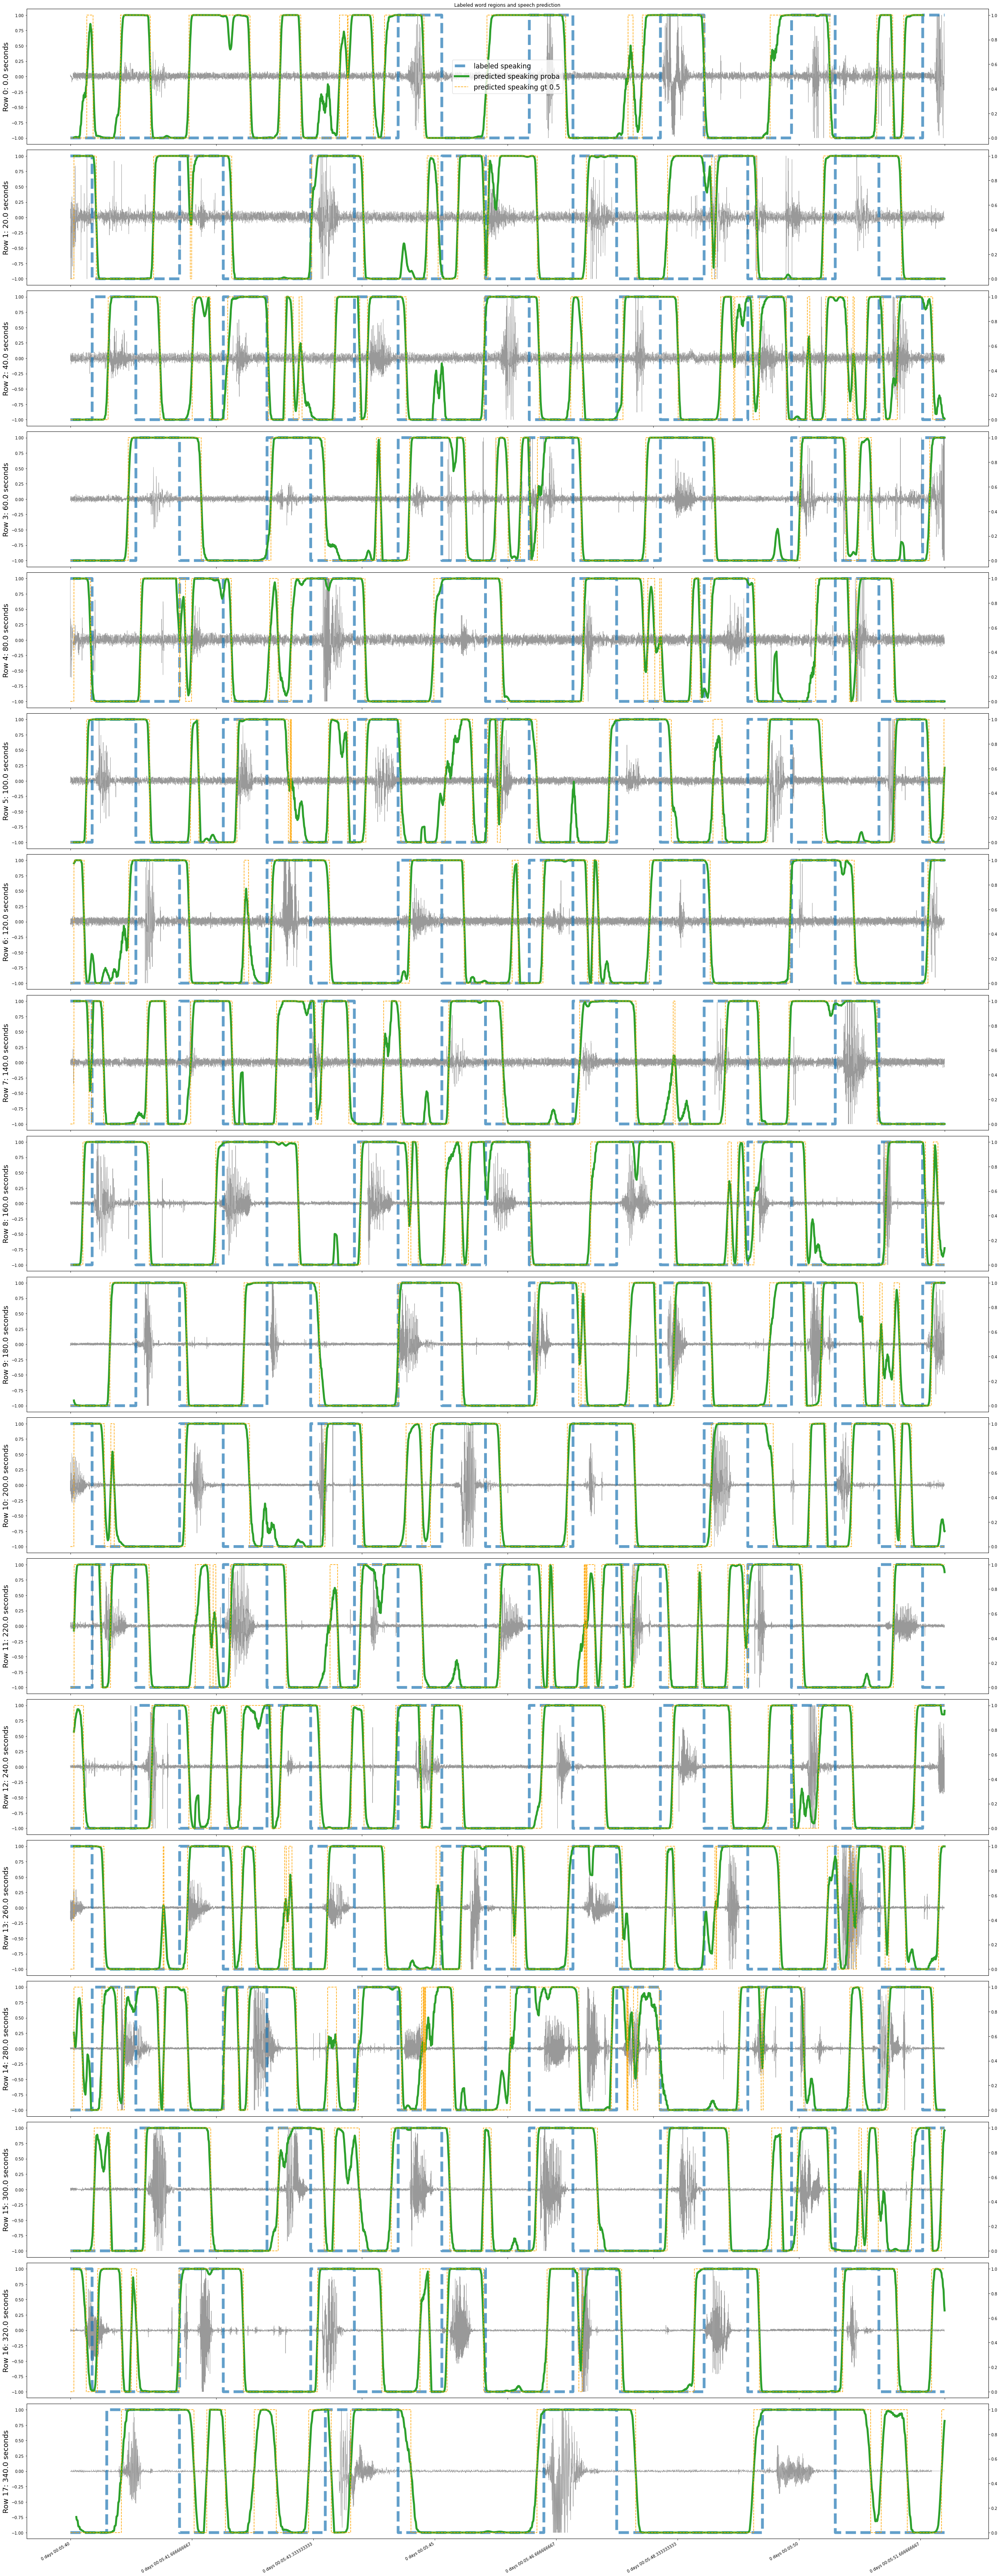

In [30]:
ix_min, ix_max = '0s', '20s'
td_ix_min, td_ix_max = pd.Timedelta(ix_min), pd.Timedelta(ix_max)
td_win_size = td_ix_max - td_ix_min

n_rows = int((data_map['audio'].index.max() / td_win_size) + 0.5)
fig, axs = matplotlib.pyplot.subplots(nrows=n_rows, figsize=(35, 5*n_rows))


ax = None
for i, ax in enumerate(axs):
    plt_ix_min = td_ix_min + (td_win_size * i)
    plt_ix_max = td_ix_max + (td_win_size * i)
    plt_audio = data_map['audio']
    
    plt_audio_mask = (plt_audio.index > plt_ix_min) & (plt_audio.index < plt_ix_max)
    plt_label_mask = (plt_label_df.index > plt_ix_min) & (plt_label_df.index < plt_ix_max)
    
    plt_audio = plt_audio.loc[plt_audio_mask].reindex(plt_label_df.loc[plt_label_mask].index, method='ffill')#.fillna(method='ffill')

    ax = (plt_audio/ plt_audio.quantile(0.999)).clip(-1, 1).plot(color='grey', alpha=0.8, lw=0.75, ax=ax, sharex=False, label='audio')
    ax.set_ylabel(f"Row {i}: {plt_ix_min.total_seconds()} seconds", fontsize=18)
    ax2 = ax.twinx()
    ax = plt_label_df.any(axis=1).astype(int).loc[plt_ix_min:plt_ix_max].plot(#color='tab:blue', 
        lw=7, ls='--', grid=True, alpha=0.7, legend=False, #figsize=(35, 6), 
        title='Labeled word regions and speech prediction' if i == 0 else '',
        label='labeled speaking',
        sharex=False,
    ax=ax2)
    plt_pred_s = all_ecog_pred_s.loc[plt_ix_min:plt_ix_max].rolling(50).mean()
    plt_pred_s.plot(ax=ax2, color='tab:green', lw=5, label='predicted speaking proba')
    (plt_pred_s > 0.5).astype(int).plot(ax=ax2, color='orange', ls='--', label='predicted speaking gt 0.5')
    if i == 0:
        ax.legend(fontsize=17)
        ax2.legend(fontsize=17)
fig.tight_layout()

### Save the figure

In [ ]:
#fig.savefig('pred_plot.pdf')